In [4]:
# !pip install networkx
# !pip install matplotlib
from collections import defaultdict, deque
import networkx as nx
import matplotlib.pyplot as plt
import json
import os
import time
from itertools import permutations
import signal

In [5]:
tasks = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E')]
delays = {'A': 1, 'B': 1, 'C': 4, 'D': 1, 'E': 3}

In [6]:
def schedule_permutations(schedule):
    for perm in permutations(schedule):
        yield perm

In [7]:
def is_valid_schedule(schedule, edges):
    task_to_index = {task: index for index, task in enumerate(schedule)}
    for u, v in edges:
        if task_to_index[u] > task_to_index[v]:
            return False
    return True

In [8]:
def inicialize_graph(edges):
    graph = defaultdict(list)
    predak = defaultdict(list)

    for u, v in edges:
        graph[u].append(v)
        predak[v].append(u)

    return graph, predak

In [9]:
def calculate_S(permutation, graph, delay, predak):
    S = {t: 0 for t in permutation}
    for node in permutation:
        max_S = S[node]
        for pred in predak[node]:
            max_S = max(S[node], S[pred] + delay[pred] + 1)

        #ako postoji node sa istim S, uvecamo ga za 1
        while max_S in S.values():
            max_S += 1
        S[node] = max_S

    return S, max(S.values())

In [10]:
class TimeoutException(Exception):
    pass

In [11]:
def timeout_handler(signum, frame):
    raise TimeoutException("Calculation failed due to timeout.")

In [24]:
#brute force alg
def brute_force_alg(tasks, edges, delays, max_seconds):
    start_time = time.time()
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(max_seconds)

    try:
        graph, predak = inicialize_graph(edges)
        min_S = float('inf')
        for permutation in schedule_permutations(tasks):
            if is_valid_schedule(permutation, edges):
                S, maximum_S = calculate_S(permutation, graph, delays, predak)
                min_S = min(maximum_S, min_S)
                best_permutation = permutation
        
        end_time = time.time()
        time_taken = end_time - start_time
        print("Best order of tasks:", best_permutation)
        print("S:", S)
        print("Minimal S:", min_S)
        print("Time taken to find the solution:", time_taken)
        return best_permutation, min_S, time_taken 
    except TimeoutException as e:
        return str(e)
    finally:
        signal.alarm(0)

In [39]:
def draw_graph(tasks, edges, delays, file_name, save_path='graphs/'):
    G = nx.DiGraph()
    
    G.add_nodes_from(tasks)
    G.add_edges_from(edges)
    pos = nx.spring_layout(G)

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1000, font_size=16, font_color='black', arrowstyle='-|>', arrowsize=10)
    
    for node, (x, y) in pos.items():
        plt.text(x + 0.05, y - 0.05, s=f"Delay: {delays[node]}", bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center', fontsize=10, color='blue')

    file_path = os.path.join(save_path, file_name)
    plt.savefig(file_path)

    plt.show()


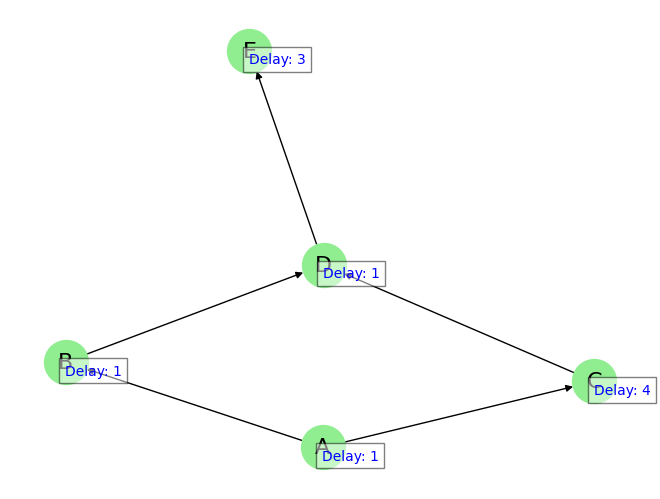

Best order of tasks: ('A', 'C', 'B', 'D', 'E')
S: {'A': 1, 'C': 3, 'B': 4, 'D': 8, 'E': 10}
Minimal S: 10
Time taken to find the solution: 0.00011110305786132812


In [40]:
tasks = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E')]
delays = {'A': 1, 'B': 1, 'C': 4, 'D': 1, 'E': 3}
draw_graph(tasks, edges, delays, "inicijalni_primer")

order_of_tasks, result, time_taken = brute_force_alg(tasks, edges, delays, 10)

In [16]:
def save_results(file, data):
    with open(file, 'w') as file:
        json.dump(data, file, indent=4)
    print(f"Data saved to {file}")

## Test on small data

In [43]:
def test_alg(path_to_test, path_to_results, time_to_calc):
    files = os.listdir(path_to_test)
    data_files = [f for f in files if f.startswith('test_file_') and f.endswith('.json')]
    data_to_write = []
    
    for file_name in data_files:
        file_path = os.path.join(path_to_test, file_name)
        with open(file_path, 'r') as f:
            loaded_data = json.load(f)
            tasks = loaded_data.get('tasks')
            edges = loaded_data.get('edges')
            delays = loaded_data.get('delays')
            
            result = brute_force_alg(tasks, edges, delays, time_to_calc)
            if(isinstance(result, str)):
                print(result)
                data = {
                'test_name' : file_name,
                'order_of_tasks': "Found none",
                }
            else:
                order_of_tasks, result, time_taken = result   
                draw_graph(tasks, edges, delays, file_name[:-5] + "_graph")
                print("----------------------------------------------")
                data = {
                'test_name' : file_name,
                'order_of_tasks': order_of_tasks,
                'finish_time': result,
                'time_taken': time_taken
                }
            data_to_write.append(data)
    
    save_results(path_to_results, data_to_write)

Best order of tasks: ('B', 'A', 'E', 'C', 'D')
S: {'B': 1, 'A': 2, 'E': 8, 'C': 9, 'D': 10}
Minimal S: 10
Time taken to find the solution: 0.00012254714965820312


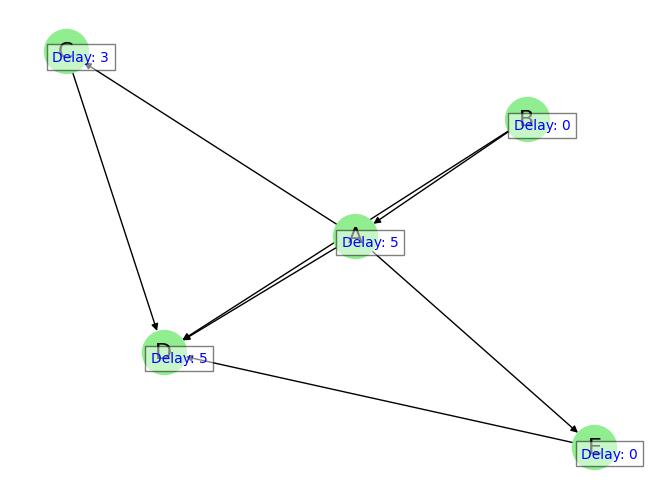

----------------------------------------------
Best order of tasks: ('B', 'D', 'G', 'C', 'E', 'H', 'A', 'F')
S: {'B': 1, 'D': 2, 'G': 7, 'C': 12, 'E': 14, 'H': 6, 'A': 8, 'F': 15}
Minimal S: 14
Time taken to find the solution: 0.030252456665039062


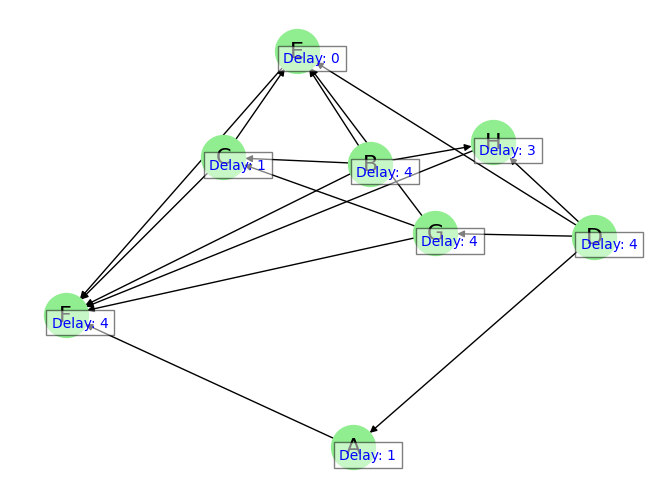

----------------------------------------------
Best order of tasks: ('B', 'D', 'E', 'A', 'F', 'C', 'G')
S: {'B': 1, 'D': 4, 'E': 2, 'A': 5, 'F': 10, 'C': 16, 'G': 17}
Minimal S: 16
Time taken to find the solution: 0.0034945011138916016


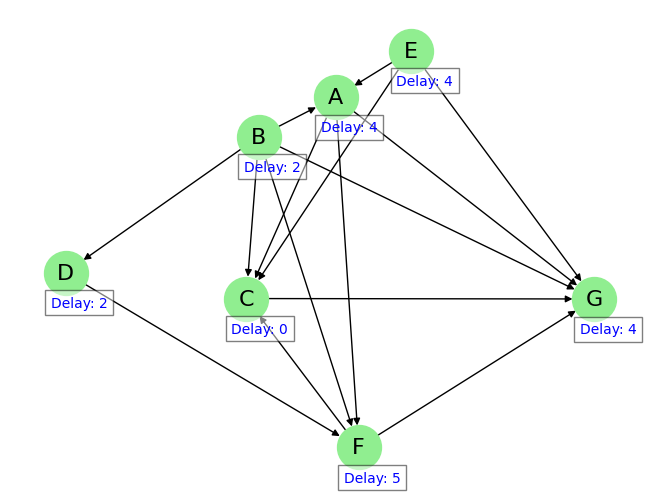

----------------------------------------------
Best order of tasks: ('B', 'F', 'E', 'A', 'C', 'D')
S: {'B': 1, 'F': 5, 'E': 7, 'A': 8, 'C': 12, 'D': 13}
Minimal S: 13
Time taken to find the solution: 0.0004837512969970703


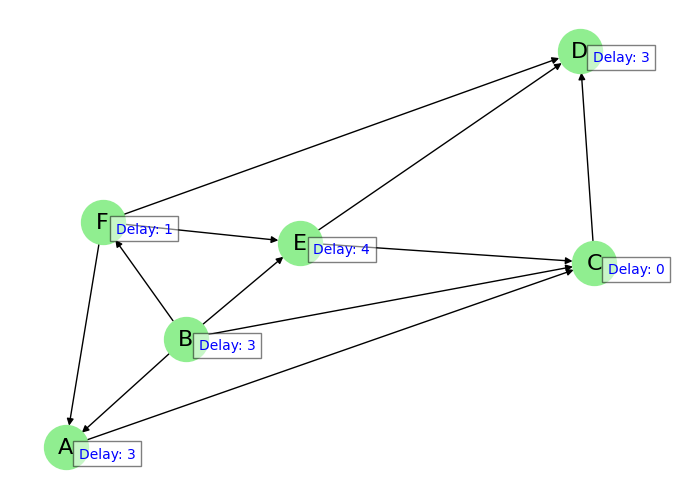

----------------------------------------------
Best order of tasks: ('B', 'A', 'C', 'G', 'H', 'E', 'D', 'I', 'F')
S: {'B': 1, 'A': 2, 'C': 3, 'G': 4, 'H': 5, 'E': 6, 'D': 9, 'I': 12, 'F': 13}
Minimal S: 11
Time taken to find the solution: 0.2698707580566406


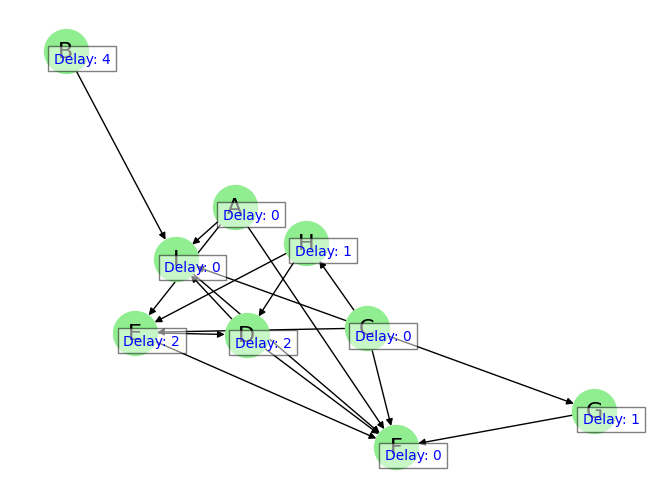

----------------------------------------------
Data saved to <_io.TextIOWrapper name='results/small_data/brute_force.json' mode='w' encoding='UTF-8'>


In [44]:
test_file = 'test_files/small_data/'
result_file = 'results/small_data/brute_force.json'
test_alg(test_file, result_file, 10)

## Test on big data

In [32]:
test_file = 'test_files/big_data/'
result_file = 'results/big_data/brute_force.json'
test_alg(test_file, result_file, 10)

Calculation failed due to timeout.
Calculation failed due to timeout.
Calculation failed due to timeout.
Calculation failed due to timeout.
Calculation failed due to timeout.
Data saved to <_io.TextIOWrapper name='results/big_data/brute_force.json' mode='w' encoding='UTF-8'>
